In [1]:
# use arldm
import sys
import os
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

/home/manikanta/miniconda3/envs/arldm/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [3]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2)) 

In [4]:
from PIL import Image
def load_512(image_path, left=0, right=0, top=0, bottom=0):
    if type(image_path) is str:
        image = np.array(Image.open(image_path))[:, :, :3]
    else:
        image = image_path
    h, w, c = image.shape
    left = min(left, w-1)
    right = min(right, w - left - 1)
    top = min(top, h - left - 1)
    bottom = min(bottom, h - top - 1)
    image = image[top:h-bottom, left:w-right]
    h, w, c = image.shape
    print(h,w)
    if h < w:
        offset = (w - h) // 2
        image = image[:, offset:offset+h]
    elif w < h:
        offset = (h - w) // 2
        image = image[offset:offset + w]

    image = np.array(Image.fromarray(image).resize((512, 512)))
    return image

In [227]:
image = load_512('/home/manikanta/text2img/MasaCtrl/wild/19/structures.jpg')

853 1280


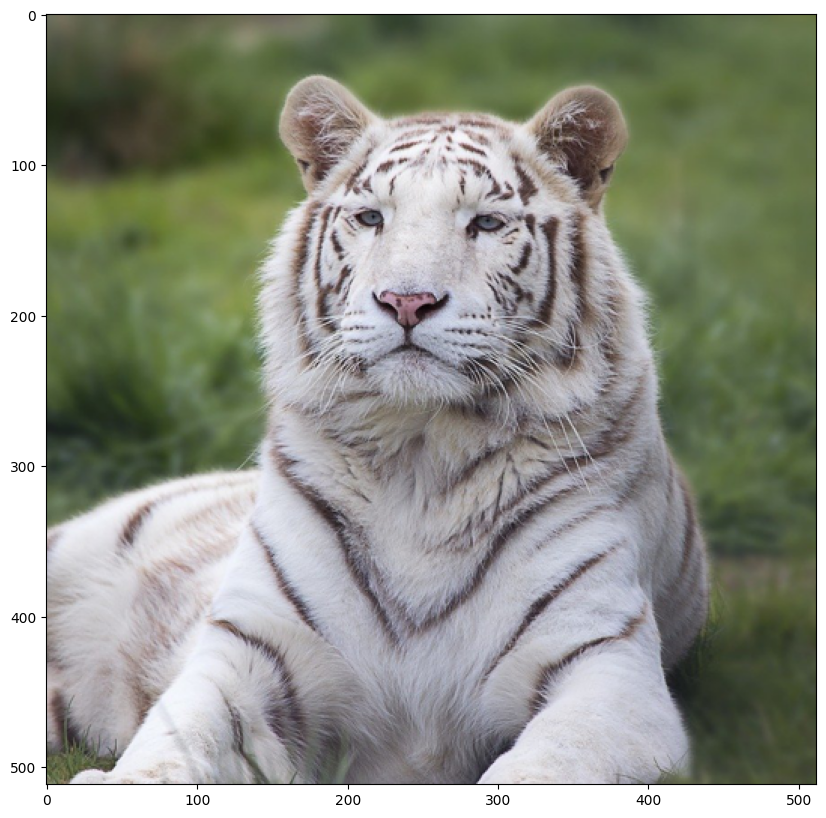

In [230]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [231]:
predictor.set_image(image)

In [233]:
input_point = np.array([[300,250]])
input_label = np.array([1])

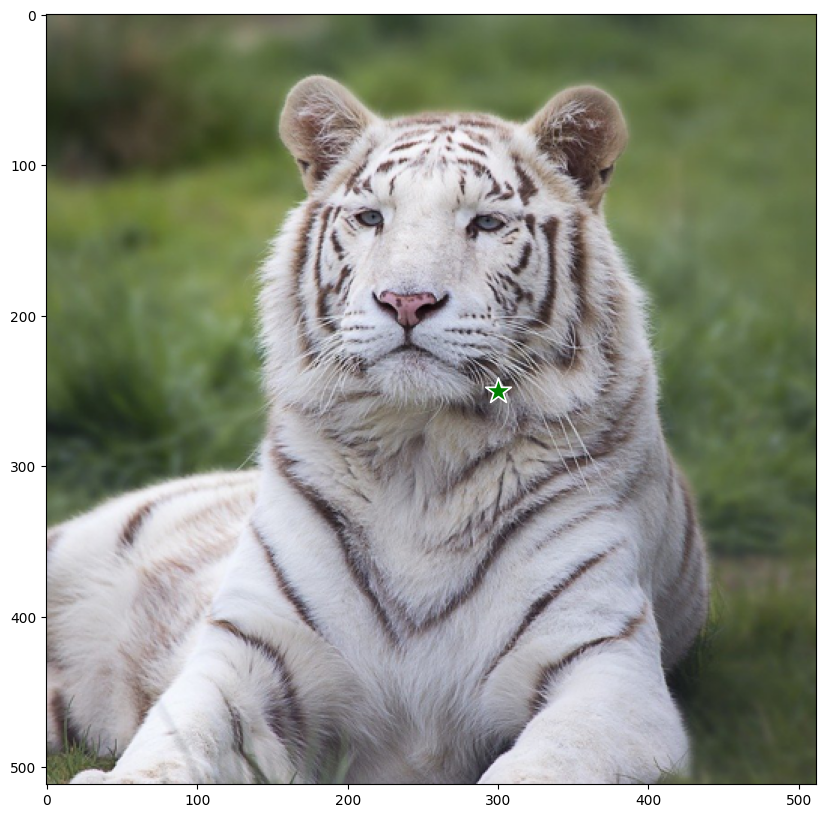

In [234]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [235]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

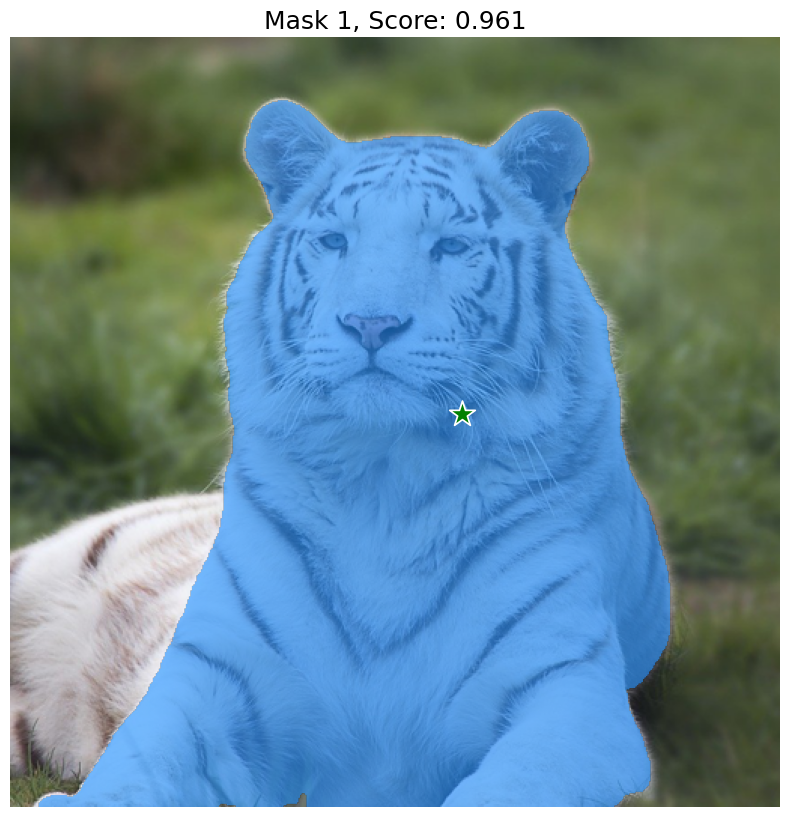

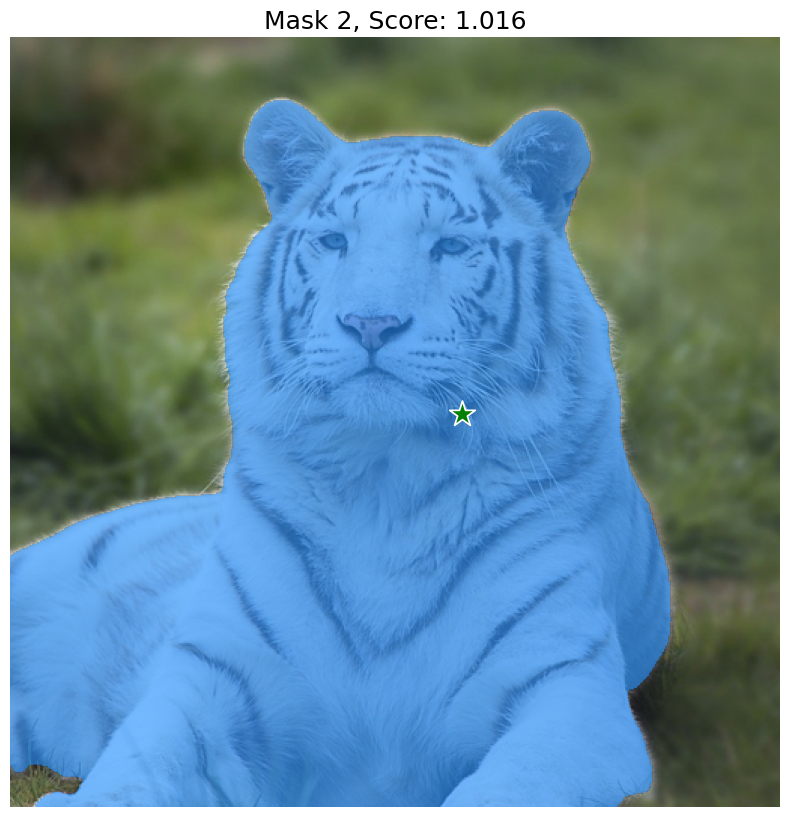

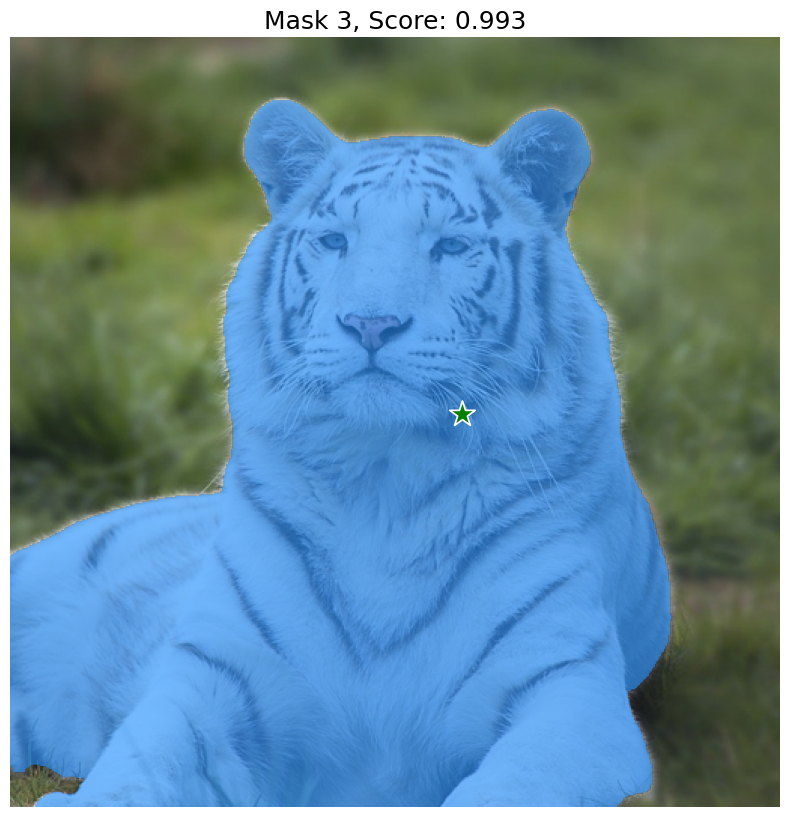

In [236]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  

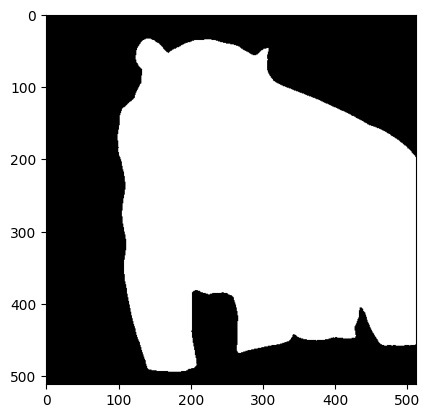

In [226]:
plt.imshow(masks[1],cmap = 'gray')

In [237]:
torch.save(masks[1],'./MasaCtrl/wild/19/structures_mask.pth')